In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NZZ/SPL"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn165251,MQDRGRRKSKSSDAAVQKVKKQPQRGMGVAQLERLRLQERWNNMTE...,243,1
1,Achn357291,MKKKKPPQRGMGVAQLERLRLQERWAKMALNNSPLQSLSPYDHPFY...,259,1
2,AA32G01105,MATSLFFISSTDHNNNNNTSLSTPNDHHLPSNTDLIRTTEPQKTRG...,318,1
3,evm_27.model.AmTr_v1.0_scaffold00072.24,MATTLLLWSPSGSPPPDDQTNDQDQENQPDQGRSRGRKSKINASGS...,293,1
4,Aqcoe1G240500.1.p,MAQEENQRCSNNNSSGGGVVRVSKKPKQKKIPQRGLGVAQLEKIRL...,435,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
108,0.009346,0.0,0.000000,0.002336,0.004673,0.000000,0.002336,0.002336,0.000000,0.000000,...,0.002336,0.002336,0.004673,0.0,0.007009,0.0,0.000000,0.0,0.0,0.000000
34,0.018018,0.0,0.000000,0.009009,0.000000,0.003003,0.000000,0.000000,0.003003,0.003003,...,0.000000,0.003003,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
11,0.007519,0.0,0.000000,0.007519,0.005013,0.002506,0.002506,0.002506,0.007519,0.000000,...,0.002506,0.002506,0.000000,0.0,0.005013,0.0,0.000000,0.0,0.0,0.002506
61,0.027778,0.0,0.002778,0.002778,0.000000,0.008333,0.002778,0.002778,0.002778,0.000000,...,0.002778,0.002778,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.002778
64,0.006006,0.0,0.000000,0.003003,0.000000,0.003003,0.003003,0.003003,0.000000,0.000000,...,0.000000,0.003003,0.000000,0.0,0.000000,0.0,0.003003,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (176, 426)
X_test: (45, 426)
y_train: (176,)
y_test: (45,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         109,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,577 (596.00 KB)

 Trainable params: 152,577 (596.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5156 - loss: 0.6931

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5036 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6921


Epoch 2/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6250 - loss: 0.6919

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5573 - loss: 0.6920 - val_accuracy: 0.5833 - val_loss: 0.6907


Epoch 3/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6562 - loss: 0.6907

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7139 - loss: 0.6903 - val_accuracy: 0.8889 - val_loss: 0.6892


Epoch 4/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8594 - loss: 0.6882

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7682 - loss: 0.6889 - val_accuracy: 0.8889 - val_loss: 0.6859


Epoch 5/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.6845

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9067 - loss: 0.6842 - val_accuracy: 0.5833 - val_loss: 0.6823


Epoch 6/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6719 - loss: 0.6812

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6330 - loss: 0.6808 - val_accuracy: 0.6111 - val_loss: 0.6766


Epoch 7/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7188 - loss: 0.6705

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6886 - loss: 0.6727 - val_accuracy: 0.8333 - val_loss: 0.6669


Epoch 8/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.6640

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9311 - loss: 0.6626 - val_accuracy: 0.8333 - val_loss: 0.6542


Epoch 9/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.6507

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8888 - loss: 0.6490 - val_accuracy: 0.8333 - val_loss: 0.6393


Epoch 10/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8281 - loss: 0.6346

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8560 - loss: 0.6311 - val_accuracy: 0.9167 - val_loss: 0.6190


Epoch 11/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.6111

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9626 - loss: 0.6091 - val_accuracy: 0.8611 - val_loss: 0.5885


Epoch 12/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.5790

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9496 - loss: 0.5716 - val_accuracy: 0.8333 - val_loss: 0.5664


Epoch 13/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8281 - loss: 0.5625

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8631 - loss: 0.5425 - val_accuracy: 0.8611 - val_loss: 0.5151


Epoch 14/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.4956

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9080 - loss: 0.4865 - val_accuracy: 0.8889 - val_loss: 0.4615


Epoch 15/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.4576

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9434 - loss: 0.4369 - val_accuracy: 0.8611 - val_loss: 0.4042


Epoch 16/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.3654

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9535 - loss: 0.3687 - val_accuracy: 0.8611 - val_loss: 0.3666


Epoch 17/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8906 - loss: 0.3477

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9229 - loss: 0.3227 - val_accuracy: 0.9167 - val_loss: 0.2975


Epoch 18/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.2413

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9834 - loss: 0.2361 - val_accuracy: 0.9167 - val_loss: 0.2462


Epoch 19/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.2155

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9701 - loss: 0.1995 - val_accuracy: 0.9167 - val_loss: 0.2100


Epoch 20/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.1778

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9776 - loss: 0.1552 - val_accuracy: 0.9167 - val_loss: 0.1717



[Train Accuracy: 97.86% - Test Accuracy: 95.56%]


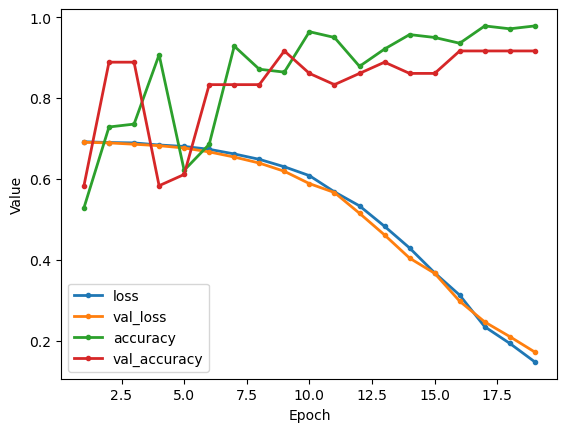

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYL,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYY
108,0.004684,0.0,0.0,0.000000,0.0,0.0,0.000000,0.002342,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.009036,0.0,0.0,0.003012,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.0,0.0,0.000000,0.0,0.0,0.002513,0.002513,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.016713,0.0,0.0,0.002786,0.0,0.0,0.000000,0.000000,0.002786,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.003012,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (176, 7585)
X_test: (45, 7585)
y_train: (176,)
y_test: (45,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       1,942,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,985,281 (7.57 MB)

 Trainable params: 1,985,281 (7.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5781 - loss: 0.6931

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5420 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6925


Epoch 2/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5156 - loss: 0.6921

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6069 - loss: 0.6921 - val_accuracy: 0.9167 - val_loss: 0.6914


Epoch 3/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8750 - loss: 0.6904

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7852 - loss: 0.6903 - val_accuracy: 0.5833 - val_loss: 0.6891


Epoch 4/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6406 - loss: 0.6874

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6638 - loss: 0.6864 - val_accuracy: 0.7222 - val_loss: 0.6850


Epoch 5/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7969 - loss: 0.6825

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8498 - loss: 0.6804 - val_accuracy: 0.7778 - val_loss: 0.6783


Epoch 6/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9219 - loss: 0.6749

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9236 - loss: 0.6710 - val_accuracy: 0.7222 - val_loss: 0.6677


Epoch 7/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.6528

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9539 - loss: 0.6529 - val_accuracy: 0.8056 - val_loss: 0.6526


Epoch 8/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.6269

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9646 - loss: 0.6273 - val_accuracy: 0.8611 - val_loss: 0.6329


Epoch 9/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.6010

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.5999 - val_accuracy: 0.8056 - val_loss: 0.6014


Epoch 10/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.5582

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9759 - loss: 0.5503 - val_accuracy: 0.7778 - val_loss: 0.5640


Epoch 11/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.5003

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9756 - loss: 0.4908 - val_accuracy: 0.8611 - val_loss: 0.5124


Epoch 12/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.4449

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.4238 - val_accuracy: 0.8889 - val_loss: 0.4497



[Train Accuracy: 100.00% - Test Accuracy: 93.33%]


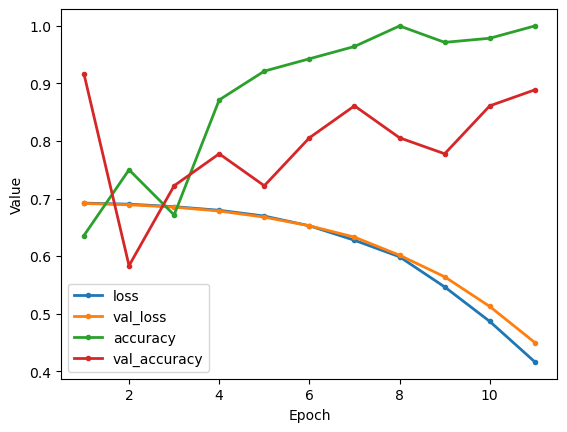

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,AAAM,...,YYST,YYTA,YYTT,YYVD,YYVP,YYVV,YYYH,YYYN,YYYT,YYYY
108,0.002347,0.0,0.000000,0.0,0.0,0.0,0.002347,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.000000,0.0,0.003021,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.011173,0.0,0.002793,0.0,0.0,0.0,0.000000,0.002793,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      11,344,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,385,345 (43.43 MB)

 Trainable params: 11,385,345 (43.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - accuracy: 0.5312 - loss: 0.6931

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5351 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6923


Epoch 2/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5312 - loss: 0.6920

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5094 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6905


Epoch 3/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4531 - loss: 0.6896

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4977 - loss: 0.6876 - val_accuracy: 0.5278 - val_loss: 0.6869


Epoch 4/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5000 - loss: 0.6837

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6062 - loss: 0.6816 - val_accuracy: 0.7500 - val_loss: 0.6819


Epoch 5/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9062 - loss: 0.6720

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8661 - loss: 0.6709 - val_accuracy: 0.7222 - val_loss: 0.6739


Epoch 6/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9375 - loss: 0.6575

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9236 - loss: 0.6560 - val_accuracy: 0.8056 - val_loss: 0.6620


Epoch 7/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9219 - loss: 0.6326

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9307 - loss: 0.6334 - val_accuracy: 0.8056 - val_loss: 0.6456


Epoch 8/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9688 - loss: 0.6111

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9811 - loss: 0.6052 - val_accuracy: 0.8056 - val_loss: 0.6238


Epoch 9/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.5637

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.5603 - val_accuracy: 0.8056 - val_loss: 0.5949


Epoch 10/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.5141

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.5082 - val_accuracy: 0.8333 - val_loss: 0.5597


Epoch 11/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.4575

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.4458 - val_accuracy: 0.8611 - val_loss: 0.5162


Epoch 12/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.3716

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.3656 - val_accuracy: 0.8333 - val_loss: 0.4665


Epoch 13/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.2924

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.2880 - val_accuracy: 0.8889 - val_loss: 0.4129


Epoch 14/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.2357

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.2225 - val_accuracy: 0.9167 - val_loss: 0.3569


Epoch 15/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.1774

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.1591 - val_accuracy: 0.9167 - val_loss: 0.3038


Epoch 16/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.1037

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0956 - val_accuracy: 0.9167 - val_loss: 0.2579


Epoch 17/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0638

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0599 - val_accuracy: 0.9167 - val_loss: 0.2212


Epoch 18/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0349

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0343 - val_accuracy: 0.9167 - val_loss: 0.1931


Epoch 19/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0224

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 0.9444 - val_loss: 0.1718


Epoch 20/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0130

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9444 - val_loss: 0.1558


Epoch 21/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0069

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9444 - val_loss: 0.1438


Epoch 22/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0047

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9444 - val_loss: 0.1345


Epoch 23/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0035

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9444 - val_loss: 0.1279


Epoch 24/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0023

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9444 - val_loss: 0.1229


Epoch 25/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0025

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9444 - val_loss: 0.1191


Epoch 26/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0015

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9444 - val_loss: 0.1160


Epoch 27/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0012

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9444 - val_loss: 0.1132


Epoch 28/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 9.9608e-04

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9444 - val_loss: 0.1105


Epoch 29/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0010

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.2045e-04 - val_accuracy: 0.9444 - val_loss: 0.1087



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


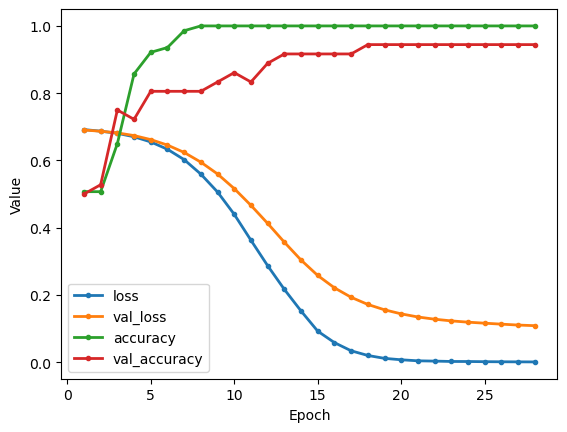

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [25]:
report.save()

Report saved as Output/Reports/NZZ__SPL/report_WT4TKB1V.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################